In [1]:
''' In this project, I will be using machine learning to create a logistic regression model that will predict whether
    a person's credit card application is approved. I will be using two datasets where applicants are matched by ID.
    The features consist of the applicant's credit history as well as other social variables. 
    I obtained this dataset on Kaggle (https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)
'''

# We first import the requied libraries

import pandas as pd
import sqlite3 as sql
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We first import the two datasets into pandas dataframes to do some initial data explotarion

df1 = pd.read_csv('/content/application_record.csv')
df2 = pd.read_csv('/content/credit_record.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [5]:
# We create a SQL database with two tables for each dataset

conn = sql.connect('test.db')
c = conn.cursor()

In [6]:
df1_column_names = df1.columns.values.tolist()

In [7]:
c.execute("CREATE TABLE applicants{}".format(tuple(df1_column_names)))
applicants = pd.read_csv('/content/application_record.csv')
applicants.to_sql('applicants', conn, if_exists='append', index= False)

438557

In [8]:
df2_column_names = df2.columns.values.tolist()

In [9]:
c.execute("CREATE TABLE record{}".format(tuple(df2_column_names)))
record = pd.read_csv('/content/credit_record.csv')
record.to_sql('record', conn, if_exists='append', index= False)

1048575

In [10]:
# Now we create a dataframe by joining the two tables based on matching IDs

df = pd.read_sql_query('''SELECT *
             FROM applicants inner join record on applicants.ID = record.ID''', conn)

In [11]:
# We drop duplicate rows

df = df.loc[:,~df.columns.duplicated()].copy()

In [12]:
df['FLAG_MOBIL'].corr(df['FLAG_PHONE'])

nan

In [13]:
df['FLAG_MOBIL'].value_counts()

1    777715
Name: FLAG_MOBIL, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

<ipython-input-15-3e1ff2525227>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")


<Axes: >

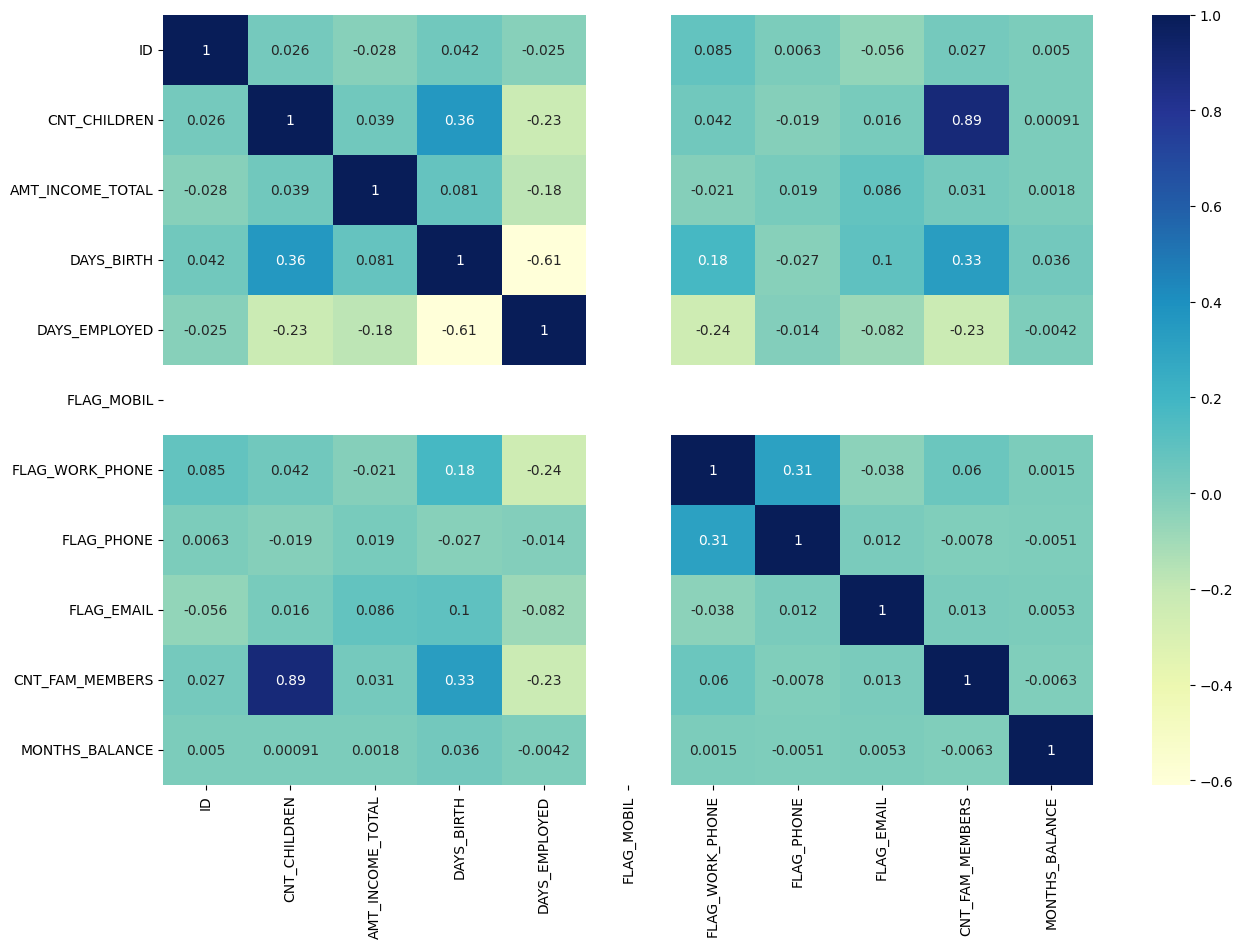

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

In [16]:
# This seems odd as the feature FLAG_MOBIL has no correlation with the other features.
# This is because all the values in this column are 1 as we can see

df['FLAG_MOBIL'].value_counts()

1    777715
Name: FLAG_MOBIL, dtype: int64

In [17]:
# Thus, we proceed to delete this column from our dataframe.

df = df.drop(['FLAG_MOBIL'], axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_WORK_PHONE      777715 non-null  int64  
 13  FLAG_PHONE           777715 non-null  int64  
 14  FLAG_EMAIL           777715 non-null  int64  
 15  OCCUPATION_TYPE  

In [19]:
# Moreover, looking at the heatmap again, we can see that the features CNT_CHILDREN and CNT_FAM_MEMBERS 
# have a strong correlation. This makes sense has more children implies more family members. 
# Thus, we remove one of this features since they carry out similar information and could bias our model.

df = df.drop(['CNT_CHILDREN'], axis=1)

In [20]:
# Similarly, we can see that the features DAYS_BIRTH and DAYS_EMPLOYED are negative correlated, and this makes sense
# as it is usually the case that an individual would have worked more days the older they are.
# Thus, we remove one of this features.

df = df.drop(['DAYS_BIRTH'], axis=1)

In [21]:
# Now that we have removed strongly correlated features, we are ready to perform transform our categorical features
# into numerical ones.

df['CODE_GENDER'] = df['CODE_GENDER'].replace(['M', 'F'], [1, 0])
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace(['Y', 'N'], [1, 0])
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace(['Y', 'N'], [1, 0])

In [22]:
df.dropna(inplace=True)

In [23]:
# Now we do one hot encoding for the categorical features

In [24]:
df = df.join(pd.get_dummies(df['NAME_INCOME_TYPE'])).drop(['NAME_INCOME_TYPE'], axis = 1)
df = df.join(pd.get_dummies(df['NAME_EDUCATION_TYPE'])).drop(['NAME_EDUCATION_TYPE'], axis = 1)
df = df.join(pd.get_dummies(df['NAME_FAMILY_STATUS'])).drop(['NAME_FAMILY_STATUS'], axis = 1)
df = df.join(pd.get_dummies(df['NAME_HOUSING_TYPE'])).drop(['NAME_HOUSING_TYPE'], axis = 1)
df = df.join(pd.get_dummies(df['OCCUPATION_TYPE'])).drop(['OCCUPATION_TYPE'], axis = 1)
df = df.join(pd.get_dummies(df['STATUS'])).drop(['STATUS'], axis = 1)

In [25]:
# Great, now that our data is cleaned, we should be able to start building our model.
# However, notice that there is no target column. That is, we are not given whether an applications was 
# approved or not. 
# We will tackle this issue by performing unsupervised learning via Clustering with K-Means (k=2)
# which will yield the target label for each sample

kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit_predict(df)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
# Perfect, now that we have our y values, we will assign these to our dataframe

df['y'] = y_pred

In [27]:
# Now we are ready to create our X and y sets and split the data into training and testing.

X = df.drop(['ID','y'], axis=1)
y = df['y']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [28]:
# Since we are going to build a logistic model we should scale our data so that our algorithm 
# performs smoothly during gradient descent

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [29]:
# Now we build our logistic regression using scikit-learn LogisticRegression

log_reg = LogisticRegression(random_state=0, max_iter=1000)

model = log_reg.fit(X_train,y_train)

In [30]:
# Finally, we compute the accuracy of our model

predictions = model.predict(X_val)
accuracy_score(y_val, predictions)

0.9996466233935314

In [31]:
# Great! we have achieved an accuracy of 99.9% and so our model is almost perfect!

In [ ]:
# While we have achieved an accuracy of 99.9% we can still make it better by using a neural network
# We will proceed to create a logistic regression model using deep learning to achieve a even higher accuracy.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
X.shape

(537667, 57)

In [34]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=[57]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/20
15122/15122 [==============================] - 41s 3ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 2/20
15122/15122 [==============================] - 37s 2ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 4.6490e-04 - val_accuracy: 0.9999
Epoch 3/20
15122/15122 [==============================] - 37s 2ms/step - loss: 8.2293e-04 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 4/20
15122/15122 [==============================] - 36s 2ms/step - loss: 5.9934e-04 - accuracy: 0.9999 - val_loss: 0.0024 - val_accuracy: 0.9998
Epoch 5/20
15122/15122 [==============================] - 36s 2ms/step - loss: 5.3076e-04 - accuracy: 0.9999 - val_loss: 3.9799e-04 - val_accuracy: 0.9999
Epoch 6/20
15122/15122 [==============================] - 36s 2ms/step - loss: 4.8702e-04 - accuracy: 0.9999 - val_loss: 3.9997e-04 - val_accuracy: 0.9999
Epoch 7/20
15122/15122 [==============================] - 35s 2ms/step - loss: 3.4259e-04 

In [35]:
# We have achieved an accuracy score of 100% with both the training and testing sets!